# Gradient Boosting

This project will explore the application of gradient boosting to real-world problems.

We will use the [data of the Yandex Real Estate service](https://drive.google.com/drive/folders/1hNo7CbzHyOk40EaGj3sTi9cjmv7_rC0F?usp=share_link): we will use the information from the ad to predict the time of its exposure on the service.

The mean absolute error (MAE) will be used to measure the quality of the models in this project.



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

data = pd.read_csv('data.tsv', sep='\t')
data = data[:100_000]
num_features = ['agent_fee', 'floor', 'floors_total', 'kitchen_area', 'living_area', 'price', 'rooms_offered', 'total_area', 'total_images']
cat_features = ['balcony', 'building_type', 'month', 'renovation', 'studio']

X_train, X_test, y_train, y_test = train_test_split(data[num_features+cat_features], data['exposition_time'], test_size=0.3, shuffle=False)

In [2]:
data.head()

,agent_fee,balcony,building_type,exposition_time,first_day_exposition,floor,floors_total,kitchen_area,living_area,month,price,renovation,rooms_offered,studio,total_area,total_images,unified_address
0,60.0,0,4,551,2018-06-30T00:00:00.000+03:00,7,9.0,9.0,31.0,June,30000,0,2,False,48.0,12,"Россия, Москва, Ясеневая улица, 10к1"
1,50.0,0,4,544,2018-06-30T00:00:00.000+03:00,5,17.0,-1.0,-1.0,June,55000,0,2,False,60.0,12,"Россия, Москва, 13-я Парковая улица, 38к2"
2,50.0,0,4,544,2018-06-30T00:00:00.000+03:00,8,17.0,12.0,-1.0,June,45000,0,2,False,68.0,13,"Россия, Москва, Щёлковское шоссе, 27"
3,60.0,0,6,551,2018-06-30T00:00:00.000+03:00,7,16.0,10.0,20.0,June,25000,0,1,False,40.0,12,"Россия, Москва, Свободный проспект, 7к1"
4,50.0,0,1,443,2018-06-30T00:00:00.000+03:00,7,14.0,8.0,30.0,June,50000,0,2,False,40.0,16,"Россия, Москва, Фестивальная улица, 59к3"


Let's start by training the Catboost model on numeric features without selection of model parameters, but with 300 trees.

In [3]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(n_estimators=300)

In [21]:
cbr.fit(X_train[num_features], y_train)
y_pred = cbr.predict(X_test[num_features])
mae_cbr = mean_absolute_error(y_test, y_pred)
print(mae_cbr)

Let't select parameters for Catboost model among these characteristics:
* max_depth {5, 7, 9};
* learning_rate {0.05, 0.1, 0.5}.

In [5]:
params = {'max_depth': [5, 7, 9],
         'learning_rate': [0.05, 0.1, 0.5]}
cbr = CatBoostRegressor(n_estimators=300, random_seed=0)

In [22]:
gs_cbr = cbr.grid_search(params, X=X_train[num_features], y=y_train, search_by_train_test_split=False)

In [11]:
gs_cbr['params']

{'depth': 7, 'learning_rate': 0.05}

In [23]:
cbr =CatBoostRegressor(n_estimators=300, random_seed=0, learning_rate=0.05, max_depth=7)
cbr.fit(X_train[num_features], y_train)
y_train_cbr = cbr.predict(X_train[num_features])
y_pred_cbr = cbr.predict(X_test[num_features])
mae = mean_absolute_error(y_test, y_pred_cbr)
print(mae)

So far, only numeric features have been used, but categorical features may also be useful for the problem.
So, let's train Catboost model with obtained optimal parametrs using categorical features.

In [24]:
cbr = CatBoostRegressor(n_estimators=300, random_seed=0, learning_rate=0.05, max_depth=7)
cbr.fit(X_train, y_train, cat_features=cat_features)

In [8]:
y_train_cbr_cf = cbr.predict(X_train)
y_pred_cbr_cf = cbr.predict(X_test)

In [9]:
mae = mean_absolute_error(y_test, y_pred_cbr_cf)
print(mae)

39.910456466458875


As an example, blending also implemented for models obtained by training with and without categorical variables.

In [10]:
from tqdm.notebook import tqdm
def select_weights(y_true, y_pred_1, y_pred_2):
    metric = []
    grid = np.linspace(0, 1, 1000)
    for w_0 in tqdm(grid):
      w_1 = 1 - w_0
      y = y_pred_1 * w_0 + y_pred_2 * w_1

      metric.append([mean_absolute_error(y_true, y), w_0, w_1])

    return metric

In [12]:
mae_blending_train, w_0, w_1 = min(select_weights(y_train, y_train_cbr, y_train_cbr_cf), key=lambda x: x[0])

In [87]:
mae_blending_train

36.14060634541386

In [88]:
print("Test MAE blending = %.4f" % mean_absolute_error(y_test, y_pred_cbr * w_0 +  y_pred_cbr_cf * w_1))

Test MAE blending = 39.9620


### Visualization of feature importance

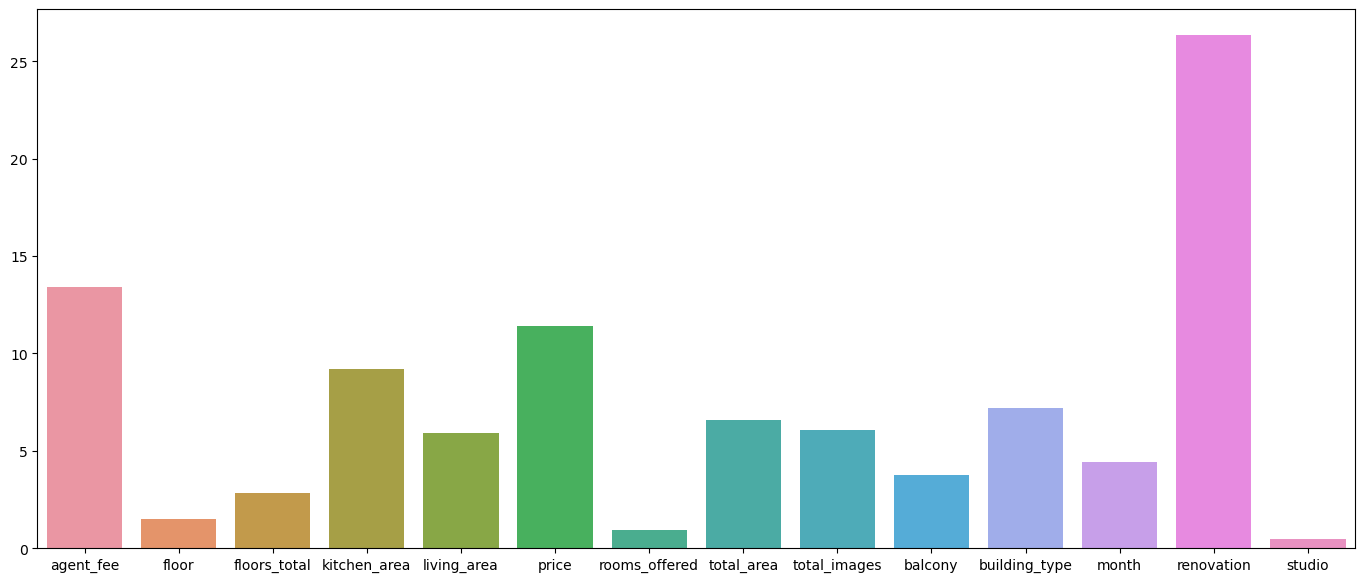

In [13]:
plt.figure(figsize=(17,7))
sns.barplot(x=X_train.columns, y=cbr.feature_importances_ );

Based on the importance of the features, let's exclude some features that have an importance below 5 and train the model again.

In [15]:
imp_col = X_train.columns[cbr.feature_importances_>5]

In [16]:
new_cat_f = ['building_type', 'renovation']

In [17]:
new_X_train = X_train[imp_col]
new_X_test = X_test[imp_col]
new_X_train.head()

,agent_fee,kitchen_area,living_area,price,total_area,total_images,building_type,renovation
0,60.0,9.0,31.0,30000,48.0,12,4,0
1,50.0,-1.0,-1.0,55000,60.0,12,4,0
2,50.0,12.0,-1.0,45000,68.0,13,4,0
3,60.0,10.0,20.0,25000,40.0,12,6,0
4,50.0,8.0,30.0,50000,40.0,16,1,0


In [25]:
cbr = CatBoostRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, random_seed=0)
cbr.fit(new_X_train, y_train, cat_features=new_cat_f)
new_y_pred = cbr.predict(new_X_test)

In [20]:
new_mae = mean_absolute_error(y_test, new_y_pred)
print(new_mae)

40.125490465971026
